In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import pi

import json
from collections import Counter
from collections import defaultdict
import numpy as np
import spacy
import pytextrank
import tensorflow as tf
import tensorflow_hub as hub
from nltk.corpus import stopwords
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix
import pandas as pd

stops = set(stopwords.words('english')) #- set(['very', 'not', 'no', 'why', 'wouldn\'t', 'won\'t'])
nlp = spacy.load("en_core_web_sm")
tr = pytextrank.TextRank(token_lookback=5)
tr.load_stopwords('stop.json')
nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)

In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


# Load the data

In [3]:
with open('filtered_nhs_since_june2019.json') as f:
    filtered_ids = json.load(f)
len(filtered_ids)

1325

In [4]:
with open('nhs_since_june2019.json') as f:
    all_articles = json.load(f)

# Functions for processing the data

In [171]:
def generate_phrases(data, field, min_text_len=3):
    '''Use spacy for generating phrases: returns phrases and sum of phrase rank'''
    phrase_count = defaultdict(int)
    for row in data:
        doc = nlp(row[field])
        for p in doc._.phrases:
            if p.rank > 0 and len(p.text) >= min_text_len:
                phrase_count[p.text] += p.rank
    return phrase_count


def regenerate_phrases(phrase_count, thesaurus):
    '''Condense the phrase count by using a thesaurus as a lookup'''
    _phrase_count = defaultdict(int)
    for text, count in phrase_count.items():
        text = thesaurus[text] if text in thesaurus else text
        _phrase_count[text] += count
    return _phrase_count

def compare(text):
    '''Return all cosine similarities in a tokenized list of terms. WARNING: memory intensive'''
    _text = [remove_stop_prefixes(terms) for terms in text]
    a = embed(_text)
    return np.inner(a, a)


def remove_prefix(prefix, phrase):
    return re.sub(f"^{prefix}", "", phrase)


def remove_stop_prefixes(phrase):
    '''Recursively remove stop words from the front of phrases. 
    Improves the efficacy of the cosine similarity score significantly'''
    _len = len(phrase)
    for stop in stops:
        _phrase = remove_prefix(f'{stop} ', phrase)
        if len(_phrase) < _len:
            return remove_stop_prefixes(_phrase)
    return phrase

def condense_phrases(text, threshold=0.79):
    '''Find groups of text (and a corresponding thesaurus) by
    using text embeddings (via TF hub) and cosine similarity.
    '''
    groups = defaultdict(list)
    thesaurus = {}
    already_grouped = set()
    for irow, (term, row) in enumerate(zip(text, compare(text))):
        if irow in already_grouped:
            continue    
        for iterm, (_term, sim) in enumerate(zip(text, row)):        
            if irow == iterm or iterm in already_grouped:
                continue
            if sim > threshold:
                thesaurus[_term] = term
                groups[term].append(_term)
                already_grouped.add(iterm)
    return groups, thesaurus

def recursive_regex_reduce(text, pattern):
    '''Recursively remove a pattern from text. Useful for large nested HTML structures.'''
    n = len(text) + 1
    while len(text) < n:
        n = len(text)
        try:
            text = re.findall(pattern, text)[0]
            if type(text) is not str:
                text = ' '.join(text)
            while '  ' in text:
                text = text.replace('  ', ' ')
            if text[-1] == ' ':
                text = text[:-1]
        except IndexError:
            continue
    return text

def remove_html_rows(text):
    '''Remove HTML table rows from a token'''
    text = recursive_regex_reduce(text, '(.*)<t.*>.*</t.*>(.*)')
    text = recursive_regex_reduce(text, '(.*)<.*t.*>(.*)')
    text = recursive_regex_reduce(text, '(.*)<td')
    return text

def make_count_vector(docs, df_mask=defaultdict(lambda:True), min_df=0, max_df=1, 
                      min_idf=0, max_idf=1, binary=False):
    '''Convert a document of term counts (list of dict[term-->count]) to a scipy count matrix.
    Build a tfidf vector whilst your at it.
    '''
    indptr = [0]
    indices = []
    data = []
    word2idx = {}
    _word2idx = {}
    transformer = TfidfTransformer()
    for term_counts in docs:
        for term, count in term_counts.items():
            index = word2idx.setdefault(term, len(word2idx))
            _index = _word2idx.setdefault(term, len(_word2idx))
            if not df_mask[_index]:
                word2idx.pop(term)
                continue
            indices.append(index)
            data.append(count)
        indptr.append(len(indices))
    idx2word = {idx:word for word, idx in word2idx.items()}
    count_vector = csr_matrix((data, indices, indptr), dtype=int).todense()    
    
    # Redo the count vector with min_df
    if min_df > 0 or max_df < 1:
        dfs = count_vector.sum(axis=0)
        df_mask = ((dfs >= min_df) & (dfs <= max_df*dfs.max())).tolist()[0]
        return make_count_vector(docs, df_mask, min_idf=min_idf, max_idf=max_idf)
    
    # Apply any tfidf filter
    tfidf_vector = transformer.fit_transform(count_vector)
    if min_idf > 0 or max_idf < 1:
        all_idfs = sorted(v for v in tfidf_vector.toarray().flatten() if v > 0)
        lower_idf, upper_idf = np.percentile(all_idfs, min_idf*100), np.percentile(all_idfs, max_idf*100)
        tfidf_condition = (tfidf_vector.toarray()  >= lower_idf) & (tfidf_vector.toarray()  <= upper_idf)
        tfidf_vector = tfidf_vector.multiply(tfidf_condition)
        count_vector = np.multiply(count_vector, tfidf_condition)
    
    # return data
    return idx2word, count_vector, tfidf_vector

# Process the articles and generate phrases

In [61]:
articles = []
for idx, rank in Counter(filtered_ids).most_common():
    art = all_articles[int(idx)]
    art['content'] = ' '.join(remove_html_rows(term) for term in art['content'].split())
    articles.append(art)

In [172]:
phrases = generate_phrases(articles, 'content')

In [173]:
len(phrases)

178836

# Condense the phrases using TF Hub embedding + cosine similarity

In [174]:
groups, thesaurus = condense_phrases({k:v for k,v in Counter(phrases).most_common(int(len(phrases)*0.1))})

In [175]:
all_phrases = sorted(list(thesaurus) + list(groups), key=lambda x: len(x), reverse=True)
all_phrases = [text for text in all_phrases if len(text) < 50]

processed_articles = []
for i, art in enumerate(articles):
    text = art['content'].lower()
    _counter = defaultdict(int)
    for p in all_phrases:
        while p in text:
            _counter[p] += 1
            text = text.replace(p, '')
    counter = defaultdict(int)
    for term, count in _counter.items():
        if term in thesaurus:
            term = thesaurus[term]
        counter[term] += count
    processed_articles.append(counter)

# Convert condensed phrases into count vectors

In [235]:
idx2word, count_vector, tfidf_vector = make_count_vector(processed_articles, 
                                                         min_df=10, max_df=0.9, 
                                                         min_idf=0.01, max_idf=0.95)

# Perform topic modelling

In [236]:
lda = LatentDirichletAllocation(n_components=20, max_iter=100, random_state=0)
lda.fit(count_vector)
for component in lda.components_:
    print([x for x, y in Counter({idx2word[idx]: weight for idx, weight in enumerate(component)}).most_common(20) if y > 10])
    print()

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=100,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

## Assuming we keep the code stable from time of writing, I have hand-labelled the below topics

In [402]:
topic_names = ['Business', 'British government', None, 'Hospitals', 'Digital systems', 'Coronavirus pandemic', None, 
               'Coronavirus research', 'Clinical trials', 'Coronavirus patients', 'British politics',
               'Workers', 'Apps and tech', 'Health problems', 'Community', 'Patients and healthcare', 
               'Anxiety', 'Cybersecurity', 'Problems with tech', 'Patients and tech']
for topic_name, component in zip(topic_names, lda.components_):
    print(topic_name)
    print([x for x, y in Counter({idx2word[idx]: weight for idx, weight in enumerate(component)}).most_common(20) if y > 10])
    print()
    
article_topics = [{topic_name: topic_weight for topic_name, topic_weight in zip(topic_names, topics) if topic_weight > 0.1 and topic_name is not None}
                  for topics in lda.transform(count_vector)]

Business
['business', 'year', 'the market', 'costs', 'results', 'time', 'a quarter', 'the question', 'opportunities', 'prices', 'the ability', 'partners', 'things', 'the number', 'last year', 'growth', 'the call', 'the company', 'revenue', 'the way']

British government
['government', 'problems', 'costs', 'the country', 'the way', 'a deal', 'the end', 'the nation', 'part', 'state', 'companies', 'concerns', 'one', 'the public', 'policy', 'a man', 'time', 'the report', 'table', 'the point']

None
['east cowick', 'the sun', 'wednesday', 'the ground', 'a man', 'day', 'the end', 'london', 'workers', 'thousands', 'the way', 'home', 'events', 'leader', 'other parts', 'staff', 'global greenings', 'hospital', 'health secretary matt hancock', 'the banks']

Hospitals
['hospital', 'university hospital', 'the north', 'nhs foundation trust', 'south', 'nhs hospitals', 'the royal marsden', 'hospitals', 'west', 'trust', 'surrey', 'years', 'liverpool', 'a man', 'england', 'patients', 'south london', 'bi

# Plot topics

In [397]:
def extract_recent_articles(article_topics, filtered_ids, limit=None, recent_date='March 1, 2020', top_topics=None):
    recent_date = pd.Timestamp(recent_date).to_pydatetime().date()
    recent_articles = []
    total_topic_weights = defaultdict(float)
    for topics, (idx, rank) in zip(article_topics, Counter(filtered_ids).most_common()):
        art = all_articles[int(idx)]
        if pd.Timestamp(art['publishedAt']).to_pydatetime().date() < recent_date:
            continue
        art['topics'] = topics
        for topic_name, topic_weight in topics.items():
            if (top_topics is not None) and (topic_name not in top_topics):
                continue
            total_topic_weights[topic_name] += topic_weight
        recent_articles.append(art)
        if limit is not None and len(recent_articles) == limit:
             break
    return recent_articles, total_topic_weights

In [400]:
def spider_plot(total_topic_weights):
    # number of variable
    sorted_topics = [(t, total_topic_weights[t]) for t in top_topics]

    categories = [k for k, v in sorted_topics]
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values = [np.log(v) if v > 1 else v/10 for k, v in sorted_topics]
    values = [v/max(values) for v in values]
    values += values[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'polar':True})

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='darkred', size=15)

    # Draw ylabels
    plt.yticks([0.33,0.66,1], ["","",""], color="grey", size=7)
    plt.ylim(0, 1)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

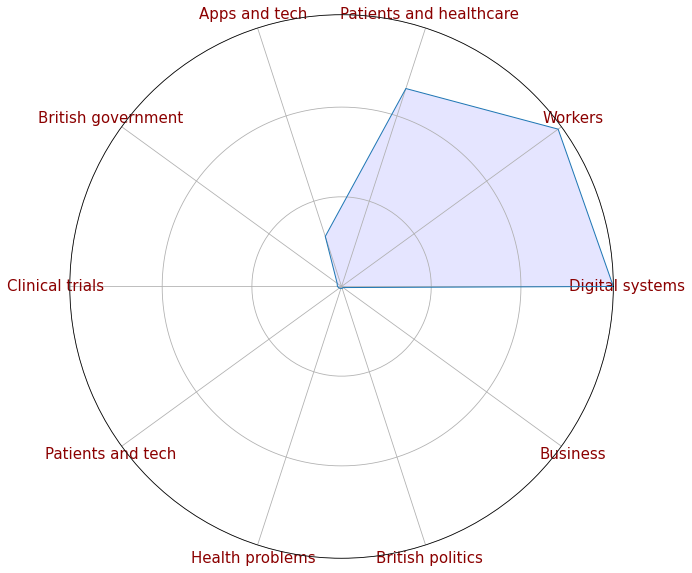

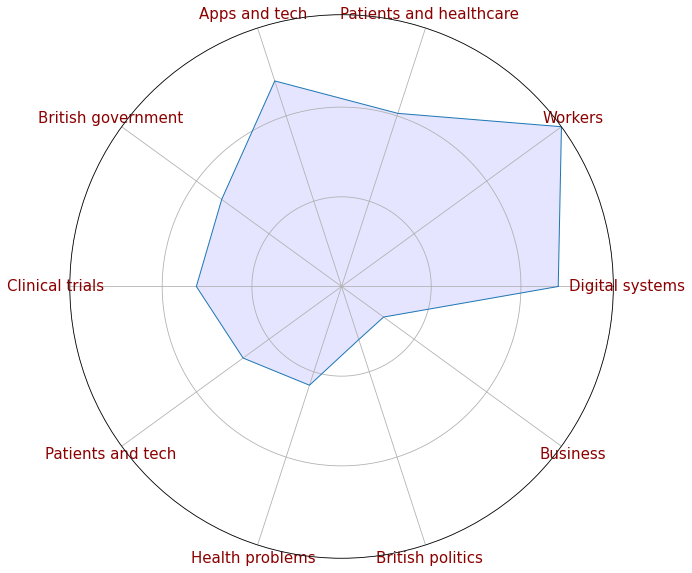

In [401]:
recent_articles, total_topic_weights = extract_recent_articles(article_topics, filtered_ids, limit=20)
spider_plot(total_topic_weights)

top_topics = [k for k, v in Counter(total_topic_weights).most_common(10)]
recent_articles, total_topic_weights = extract_recent_articles(article_topics, filtered_ids, top_topics=top_topics)
spider_plot(total_topic_weights)